In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [3]:
class Dataset_torch(Dataset):

    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data['y'])    

    def __getitem__(self, idx):
        
        inputs = [self.data['x1'][idx],self.data['x2'][idx].float()]
        return inputs, self.data['y'][idx]
        

In [4]:
data_18 = torch.load('/content/drive/MyDrive/sar_img/dataset/tensors_2018.pt')
dataset_2018 = Dataset_torch(data_18)
data_loader_2018 = torch.utils.data.DataLoader(dataset=dataset_2018, batch_size=1024,num_workers=2)

In [51]:
index_all = []
for i in range(22):
    index_all.append(torch.nonzero((data_18['y'][:,0] > i*0.5) & (data_18['y'][:,0] < (i+1)*0.5)))

In [11]:
data_18_y = data_18['y'].to(device)

# Prediction of Avg6 - data augmentation - model

In [38]:
class Net_spectral(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        # self.conv4 = nn.Conv2d(256, 512, 3)

        self.maxpooling2d = nn.MaxPool2d(2, 2)
        self.globalmaxpooling2d = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.5)

        self.fc512_n1 = nn.Linear(256, 256)
        self.fc512_n2 = nn.Linear(256, 256)

    def forward(self, x):
        x = self.maxpooling2d(F.relu(self.conv1(x)))
        x = self.maxpooling2d(F.relu(self.conv2(x)))
        x = self.maxpooling2d(F.relu(self.conv3(x)))
        # x = self.maxpooling2d(F.relu(self.conv4(x)))
        x= self.globalmaxpooling2d(x)
        x = F.relu(self.fc512_n1(torch.squeeze(x)))

        x = F.relu(self.fc512_n2(x))
        x = self.dropout(x)
        return x

class MLP_output(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.dropout_n1 = nn.Dropout(p=0.5)
        self.dropout_n2 = nn.Dropout(p=0.5)
        self.dropout_n3 = nn.Dropout(p=0.5)


        self.fc256 = nn.Linear(256, 256)

        # self.fc1024_512 = nn.Linear(1024, 512)
        self.fc512_256 = nn.Linear(512, 256)
        self.fc256_128 = nn.Linear(256, 128)
        self.fc128_2 = nn.Linear(128,2)

    def forward(self, x):


        # x = F.relu(self.fc1024_512(x))
        # x = self.dropout_n1(x)
        # x = F.relu(self.fc512_256(x))
        # x = self.dropout_n2(x)
        x = F.relu(self.fc256_128(x))
        x = self.dropout_n3(x)

        output = F.softplus(self.fc128_2(x))

        return output



class Net_cwave(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim = 1)


        self.fc10_64 = nn.Linear(10, 64)
        self.fc64_128 = nn.Linear(64, 128)
        self.fc128_256 = nn.Linear(128, 256)
        self.fc256_512 = nn.Linear(256, 512)
        self.fc512_1024 = nn.Linear(512, 1024)
        self.fc1024_2048 = nn.Linear(1024,2048)

    def forward(self, x):
        x = F.relu(self.fc10_64(x[:,22:]))
        x = F.relu(self.fc64_128(x))
        x = F.relu(self.fc128_256(x))
        x = F.relu(self.fc256_512(x))
        x = F.relu(self.fc512_1024(x))
        x = F.relu(self.fc1024_2048(x))
        x = x.view(-1,8,256)

        x = self.softmax(x)
        x = self.dropout(x)
        return x

# combination of two NN
class Net_comb(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.maxpooling2d = nn.MaxPool2d(2, 2)
        self.globalmaxpooling2d = nn.AdaptiveMaxPool2d(1)

        self.dropout_n1 = nn.Dropout(p=0.5)
        self.dropout_n2 = nn.Dropout(p=0.5)

        self.fc256 = nn.Linear(256, 256)
        self.fc256_128 = nn.Linear(256, 128)
        self.fc128_1 = nn.Linear(128, 1)

        self.net_cwave = Net_cwave()

        self.net_spectral_n1 = Net_spectral()
        self.net_spectral_n2 = Net_spectral()
        self.net_spectral_n3 = Net_spectral()
        self.net_spectral_n4 = Net_spectral()
        self.net_spectral_n5 = Net_spectral()
        self.net_spectral_n6 = Net_spectral()
        self.net_spectral_n7 = Net_spectral()
        self.net_spectral_n8 = Net_spectral()

        self.mlp_out = MLP_output()
        # self.mlp_out_2 = MLP_output()

    def forward(self, x1,x2):

        cnn_output_n1 = self.net_spectral_n1(x1)
        cnn_output_n2 = self.net_spectral_n2(x1)
        cnn_output_n3 = self.net_spectral_n3(x1)
        cnn_output_n4 = self.net_spectral_n4(x1)
        cnn_output_n5 = self.net_spectral_n5(x1)
        cnn_output_n6 = self.net_spectral_n6(x1)
        cnn_output_n7 = self.net_spectral_n7(x1)
        cnn_output_n8 = self.net_spectral_n8(x1)

        cnn_output_matrix = torch.cat([cnn_output_n1,cnn_output_n2,cnn_output_n3,cnn_output_n4,cnn_output_n5,cnn_output_n6,cnn_output_n7,cnn_output_n8],dim=1)
        cnn_output_matrix = cnn_output_matrix.view(-1,8,256)
        # print(self.net_cwave(x2).size())
        # print(cnn_output_matrix.size())
        x = cnn_output_matrix*self.net_cwave(x2)

        x = torch.sum(x,1)

        output = self.mlp_out(x)

        return output


    def training_step(self, batch, batch_idx):
        x, y_true = batch
        x1,x2 = x

        x1 = torch.cat([x1, torch.cat([torch.unsqueeze(x1[:,0,:,:],1),torch.unsqueeze(torch.zeros_like(x1[:,1,:,:]),1)],1)],0)
        x2 = torch.cat([x2,x2],0)

        y_pre = self.forward(x1,x2)


        loss_f = nn.GaussianNLLLoss()
        loss = loss_f(y_pre[:,0], torch.cat([torch.squeeze(y_true).float(),torch.squeeze(y_true).float()],0) ,y_pre[:,1])
        self.log('train_loss', loss)

        return loss



    def validation_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x
        
        y_pre = self.forward(x1,x2)

        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('val_loss', loss)
    
        return loss

    def test_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x
        
        y_pre = self.forward(x1,x2)
        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('test_loss', loss)
        
        return loss

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        scheduler = ReduceLROnPlateau(optimizer, factor=0.8, patience= 1)

        return { 'optimizer': optimizer, 'lr_scheduler': { 'scheduler': scheduler, 'monitor': 'val_loss', } }

In [39]:


class Net_comb_6(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.m1 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v1/lightning_logs/version_6/checkpoints/epoch=31-step=71199.ckpt')
        self.m2 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v1/lightning_logs/version_8/checkpoints/epoch=31-step=71199.ckpt')
        self.m3 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v2/lightning_logs/version_0/checkpoints/epoch=31-step=71199.ckpt')
        self.m4 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v2/lightning_logs/version_2/checkpoints/epoch=31-step=71199.ckpt')
        self.m5 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v2/lightning_logs/version_3/checkpoints/epoch=31-step=71199.ckpt')
        self.m6 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v2/lightning_logs/version_7/checkpoints/epoch=31-step=71199.ckpt')

    def forward(self, x1,x2):

        out = torch.cat([torch.unsqueeze(self.m1(x1,x2),2),torch.unsqueeze(self.m2(x1,x2),2),torch.unsqueeze(self.m3(x1,x2),2),torch.unsqueeze(self.m4(x1,x2),2),torch.unsqueeze(self.m5(x1,x2),2),torch.unsqueeze(self.m6(x1,x2),2)],2)
        out = torch.mean(out,2)


        return out

    def training_step(self, batch, batch_idx):
        x, y_true = batch
        x1,x2 = x

        x1 = torch.cat([x1, torch.cat([torch.unsqueeze(x1[:,0,:,:],1),torch.unsqueeze(torch.zeros_like(x1[:,1,:,:]),1)],1)],0)
        x2 = torch.cat([x2,x2],0)

        y_pre = self.forward(x1,x2)


        loss_f = nn.GaussianNLLLoss()
        loss = loss_f(y_pre[:,0], torch.cat([torch.squeeze(y_true).float(),torch.squeeze(y_true).float()],0) ,y_pre[:,1])
        self.log('train_loss', loss)

        return loss



    def validation_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x
        
        y_pre = self.forward(x1,x2)

        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('val_loss', loss)
    
        return loss

    def test_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x
        
        y_pre = self.forward(x1,x2)
        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('test_loss', loss)
        
        return loss

    def predict_step(self, batch, batch_idx):
        x, y_true = batch
        x1,x2 = x

        y_pre = self.forward(x1,x2)
        return y_pre

    def configure_optimizers(self):
        
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        scheduler = ReduceLROnPlateau(optimizer, factor=0.8, patience= 4)

        return { 'optimizer': optimizer, 'lr_scheduler': { 'scheduler': scheduler, 'monitor': 'val_loss', } }
    

In [40]:
model_6 = Net_comb_6()
trainer = pl.Trainer(gpus=1)
predict_2018_test_k8_avg6_aug_fix = trainer.predict(model=model,dataloaders = data_loader_2018)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [43]:
predict_2018_test_k8_avg6_aug_fix = torch.cat(predict_2018_test_k8_avg6_aug_fix)

In [44]:
torch.save(predict_2018_test_k8_avg6_aug_fix, '/content/drive/MyDrive/sar_img/dataset/predict_2018_test_k8_avg6_aug_fix.pt')

## Compute MSE

In [58]:
mse_all = []
for i in range(22):
    mse_all.append(F.mse_loss( predict_2018_test_k8_avg6_aug_fix[index_all[i]][:,0,0],data_18_y[index_all[i]][:,0,0]))

In [ ]:
def compute_std(y1,y2,mse):
  up_term = torch.sum( torch.square( torch.abs(y1-y2) -mse ) )
  # print(y2)
  return torch.sqrt(up_term/(len(y1)-1))

In [ ]:
std_best = []
for i in range(22):
  std_best.append(compute_std(predict_2018_original_karas[index_all[i]],data_18[index_all[i]],mse_all[i]))

In [68]:
std_best = [0.346293509668832, 0.2669369590439979, 0.1893558155728894, 0.1835228738051674, 0.20555901872608823, 0.2383246978739601, 0.26852720578324063, 0.2847142259062558, 0.3034396282285795, 0.3315791987107695, 0.34874240202527695, 0.36145532072824876, 0.4192678015180254, 0.44887291635551835, 0.4502445293083892, 0.5780729867662545, 0.6036670043685681, 0.6446478310600051, 0.7199428374314153, 0.8764436406653068, 0.9053146452036906, 0.7252625812082377]
std_keras = [0.41180476, 0.22910242, 0.18434748, 0.16902889, 0.17857188, 0.21085177,  0.24339817, 0.269533, 0.29677658, 0.32883034, 0.35269653, 0.37402833, 0.430864, 0.49374193, 0.4860231, 0.61558132, 0.63948027, 0.66401288, 0.79175267, 0.77932534, 0.71254386,0.87591156]

In [ ]:
mse_all_keras = [0.76144022, 0.22804827, 0.08137827, 0.05065597, 0.0592405, 0.08194562, 0.11086507, 0.1402572, 0.17046906, 0.20742064, 0.24115346, 0.28746564, 0.37837055, 0.47789985, 0.5263376, 0.86976685, 0.89072914, 1.16020258, 1.53541453, 1.58775931, 1.75512802,2.25546595]

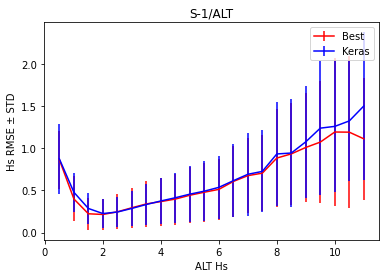

In [72]:
plt.errorbar(np.arange(1,23)*0.5, np.sqrt(mse_all),c='r'  , yerr=std_best
plt.errorbar(np.arange(1,23)*0.5, np.sqrt(mse_all_keras),c='b'  , yerr=std_keras,label='Keras')
plt.title('S-1/ALT')
plt.ylabel('Hs RMSE ± STD')
plt.xlabel('ALT Hs')
plt.legend()